In [1]:
import torchaudio as ta
import torchaudio.transforms as T
import torch
import numpy as np
import yaml
# import mir_eval
import gc
import warnings
# from train import RTBWETrain
# from datamodule import *
from utils import *
from tqdm import tqdm
import wandb
import random
from torch.utils.data import Subset
import soundfile as sf
from datetime import datetime
import sys
import torch.nn.functional as F
import argparse

from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
# from SEANet_v2 import SEANet_ver2
from models.SEANet_TFiLM_nok import SEANet_TFiLM as SEANet_TFiLM_nok
from models.SEANet_TFiLM_nok_modified import SEANet_TFiLM as SEANet_TFiLM_nokmod

from MelGAN import Discriminator_MelGAN
from MBSTFTD import MultiBandSTFTDiscriminator

from dataset import CustomDataset

from models.SEANet_TFiLM import SEANet_TFiLM
from models.SEANet import SEANet
from IPython.display import display, Audio

/home/woongjib/anaconda3/envs/env2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-16 17:32:08.374983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 17:32:09.037801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# """ Load DataLoader """
# """ 원본에 비해 fir 은 앞에 100을 crop 해야함 """
# path_wb = [
#             "/mnt/hdd/Dataset/FSD50K_48kHz/FSD50K.eval_audio", 
#             "/mnt/hdd/Dataset/MUSDB18_HQ_mono_48kHz/test", 
#             ]
# path_nb = [
#             "/mnt/hdd/FSD50K_CORE_fir/FSD50K.eval_audio", 
#             "/mnt/hdd/MUSDB18_CORE_fir/test", 
#             ]

# dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=1, mode="train")

# """ Load Model """
# # model = SEANet()
# # path = "/home/woongjib/Projects/BESSL__/ckpt_baseline/epoch_5_lsdH_0.596.pth"

# # 64 model
# model = SEANet_TFiLM(kmeans_model_path="/home/woongjib/Projects/BESSL__/kmeans/K64_MAE.pkl")
# path = "/home/woongjib/Projects/BESSL__/ckpts/ckpt_BESSL_AAC13.5/ckpt_K64/epoch_41_lsdH_0.441.pth"

# # nok model
# # model = SEANet_TFiLM_nok()
# # path = "/home/woongjib/Projects/BESSL__/ckpts/ckpt_BESSL_AAC13.5/ckpt_nok/epoch_13_lsdH_0.430.pth"

# ## No FT, scratch model
# # model = SEANet_TFiLM_nokmod(in_channels=64)
# # path = "/home/woongjib/Projects/BESSL__/ckpts/ckpt_D64m/epoch_1_lsdH_0.455.pth"

# ckpt = torch.load(path)
# ckpt = ckpt['generator_state_dict']

# model.load_state_dict(ckpt)

# ### Music Data
# path_wb = [
#             "/mnt/hdd/Dataset/MUSDB18_HQ_mono_48kHz/test", 
#             ]
# path_nb = [
#             "/mnt/hdd/MUSDB18_CORE_fir/test", 
#             ]

# mus_dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=1, mode="train")

# # no FT, scratch model
# model2 = SEANet_TFiLM_nokmod(in_channels=64)
# path = "/home/woongjib/Projects/BESSL__/ckpts/ckpt_D64m/epoch_7_lsdH_0.417.pth"

# ckpt = torch.load(path)
# ckpt = ckpt['generator_state_dict']
# model2.load_state_dict(ckpt)

In [44]:
path_wb = [
            "/mnt/hdd/Dataset_BESSL/FSD50K_WB_SEGMENT/", 
            "/mnt/hdd/Dataset_BESSL/MUSDB_WB_SEGMENT/", 
            
            ]
path_nb = [
            "/mnt/hdd/Dataset_BESSL/FSD50K_LPF/", 
            "/mnt/hdd/Dataset_BESSL/MUSDB_LPF/", 
            
            ]
# dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=1, mode="train")


""" nb에서 100을 crop 해야하는 이유 """
# path_wb = [
#             "/mnt/hdd/Dataset/FSD50K_48kHz/FSD50K.eval_audio", 
#             "/mnt/hdd/Dataset/MUSDB18_HQ_mono_48kHz/test", 
#             ]
# path_nb = [
#             "/mnt/hdd/FSD50K_CORE_fir/FSD50K.eval_audio", 
#             "/mnt/hdd/MUSDB18_CORE_fir/test", 
#             ]

dataset = CustomDataset(path_dir_nb=path_nb, path_dir_wb=path_wb, seg_len=0.9, mode="train")


Index:0 with 283048 samples
Index:1 with 144773 samples
LR 427821 and HR 427821 file numbers loaded!
train: 427821 files loaded


short
tensor([[177884]]) 356842_mono_segment_3


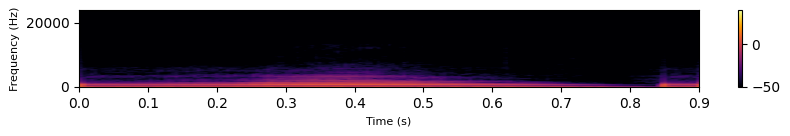

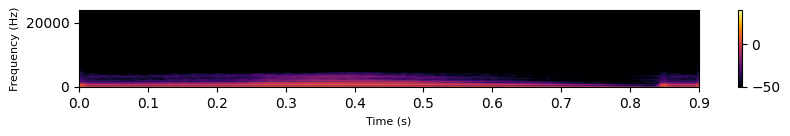

torch.Size([1, 43200]) torch.Size([1, 43200])


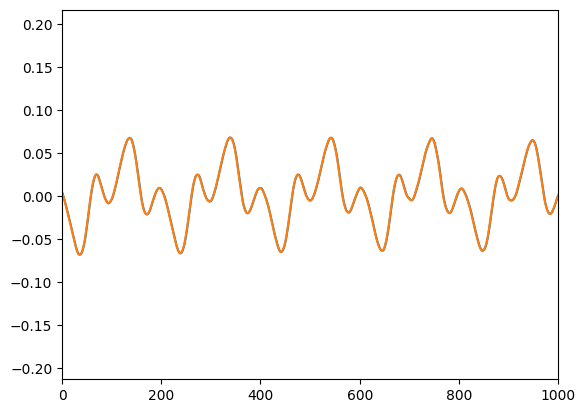

In [54]:

idx = torch.randint(1,300000, (1,1))
# idx = 19036
wb, nb, spec, name, label = dataset[idx]
print(idx, name)
a = draw_spec(wb.squeeze().numpy(), sr=48000, figsize=(10,1))
a = draw_spec(nb.squeeze().numpy(), sr=48000, figsize=(10,1))
display(Audio(wb,rate=48000))
display(Audio(nb,rate=48000))

# nb = nb[:,100:]
plt.plot(wb.squeeze())
plt.plot(nb.squeeze())
plt.xlim(0,1000)
# plt.xlim(43000,43200)
print(wb.shape, nb.shape)

tensor([[116]])
108750_mono


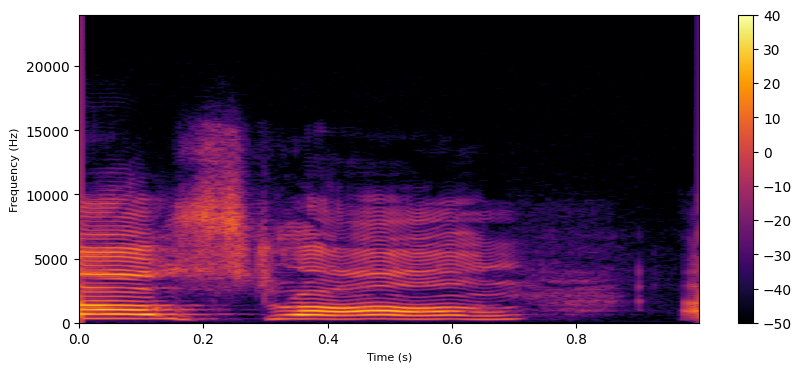

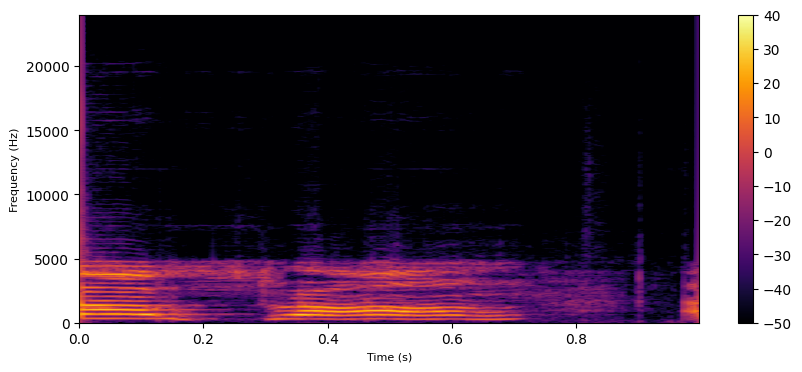

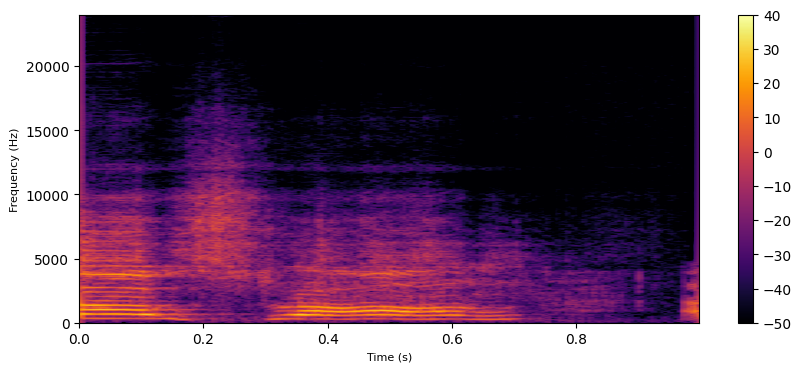

In [90]:
idx = torch.randint(1,250,size=(1,1))
print(idx)
idx = 231
# idx = 90, 11, 231
wb, nb, spec, name, label = dataset[idx]
# wb, nb, spec, name, label = mus_dataset[idx]
print(name)

wb = wb[:, :-100]
nb = nb[:, 100:]
a = draw_spec(wb.squeeze().numpy(), sr=48000, figsize=(10,4))
# a = draw_spec(nb.squeeze().numpy(), sr=48000, figsize=(10,4))
display(Audio(wb, rate=48000))
# display(Audio(nb, rate=48000))

with torch.no_grad():
    out = model(nb, spec)
    out2 = model2(nb, spec)

a = draw_spec(out.squeeze().numpy(), sr=48000, figsize=(10,4))
display(Audio(out.squeeze().numpy(), rate=48000))

a = draw_spec(out2.squeeze().numpy(), sr=48000, figsize=(10,4))
display(Audio(out2.squeeze().numpy(), rate=48000))